In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [114]:
df = pd.read_csv('daily_occupancy.csv')

df.head()

,fecha,ocupacion,cuartos,dia_festivo,semana_ano,mes,trimestre,ano,lag_1,lag_2,lag_4,semana_inicio
0,2019-02-13,1006,506,0,7,2,1,2019,0.0,0.0,0.0,2019-02-11
1,2019-02-14,1121,560,0,7,2,1,2019,1006.0,0.0,0.0,2019-02-11
2,2019-02-15,1249,584,0,7,2,1,2019,1121.0,1006.0,0.0,2019-02-11
3,2019-02-16,1251,590,0,7,2,1,2019,1249.0,1121.0,0.0,2019-02-11
4,2019-02-17,912,445,0,7,2,1,2019,1251.0,1249.0,1006.0,2019-02-11


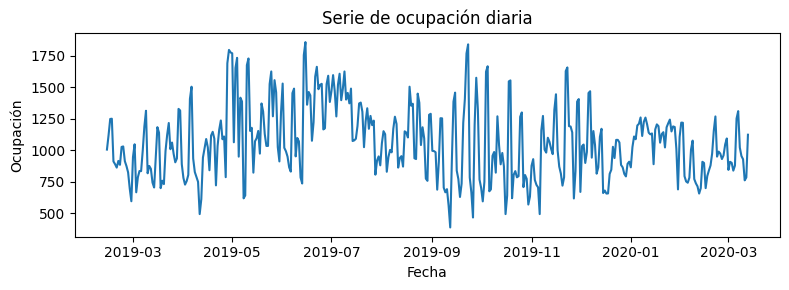

In [115]:
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha').sort_index()

# trend general de la serie de ocupacion
plt.figure(figsize=(8, 3))
plt.plot(df['ocupacion'])
plt.title('Serie de ocupación diaria')
plt.xlabel('Fecha')
plt.ylabel('Ocupación')
plt.tight_layout()
plt.show()


In [116]:
# la serie que queremos predecir!
serie = df['ocupacion']

# dividimos en train y test
horizonte = 30
train = serie[:-horizonte]
test = serie[-horizonte:]

print(f"Shape train: {train.shape}")
print(f"Shape test: {test.shape}")
print("Primer día de test:", test.index[0])
print("Último día de test:", test.index[-1])

Shape train: (365,)
Shape test: (30,)
Primer día de test: 2020-02-13 00:00:00
Último día de test: 2020-03-13 00:00:00


In [117]:
adf_result = adfuller(train)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
# Si p-value < 0.05, la serie es estacionaria. Si no, hay que diferenciar (d=1)

ADF Statistic: -2.734333056318894
p-value: 0.06828323657185999


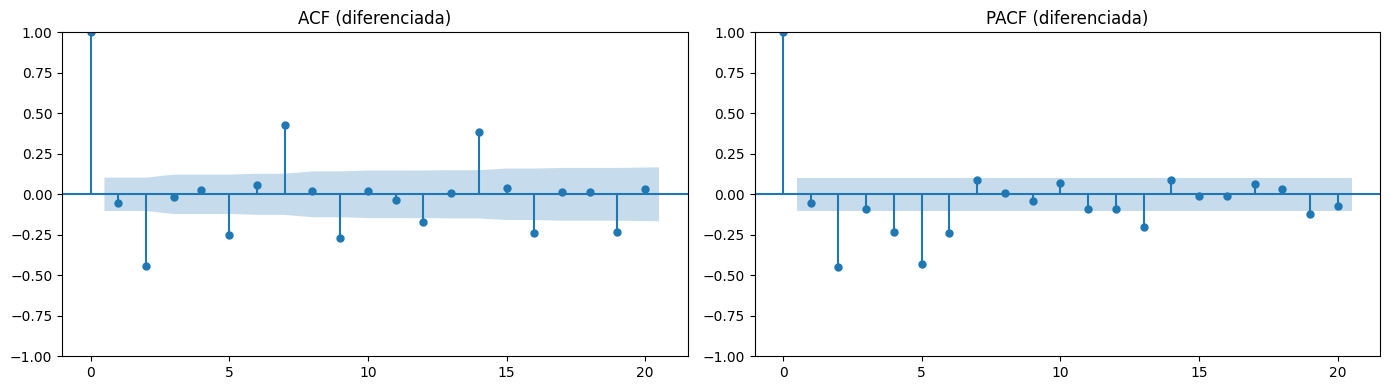

In [118]:
# tenemos un valor p de 0.068, lo que quiere decir que la serie no es estacionaria, por lo que hay
# que diferenciar (d=1)
# Serie diferenciada si la serie no fue estacionaria
diff_series = train.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff_series, lags=20, ax=axes[0])
axes[0].set_title('ACF (diferenciada)')
plot_pacf(diff_series, lags=20, ax=axes[1])
axes[1].set_title('PACF (diferenciada)')
plt.tight_layout()
plt.savefig('arima_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

# Con base en lo visual (pico en lag 1 en ambos): p=1, d=1, q=1 sugerido

43  (3, 1, 3)  103.858842  10.883634  132.704030
17  (1, 1, 1)  111.151518  11.702993  145.381050
39  (3, 0, 3)  117.746593  12.703667  147.534104
7   (0, 1, 3)  111.819345  11.646654  147.546405
18  (1, 1, 2)  111.732755  11.609678  147.821145

MAE: 111.73
MPE: 11.61%
RMSE: 147.82


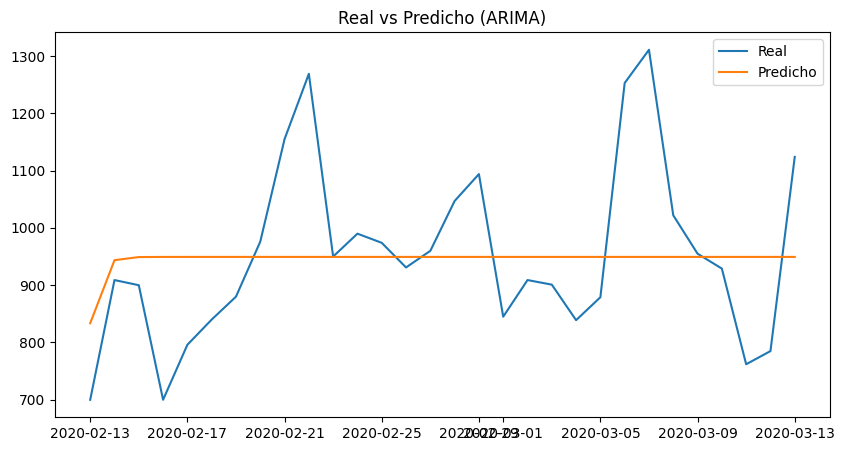

In [119]:
# definimos orden en base a lags
order = (1, 1, 2)

# Entrena el modelo ARIMA(1,1,1)
model = ARIMA(train, order=order)
modelo_fit = model.fit()

# Haz predicción one-step-ahead para cada punto del test set
# Predicción de los próximos 30 días
pred = modelo_fit.forecast(steps=horizonte)
pred.index = test.index  # Para que los índices coincidan

# Cálculo de métricas
mae = mean_absolute_error(test, pred)
mpe = ((pred - test) / test).abs().mean() * 100
rmse = root_mean_squared_error(test, pred)

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
# plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Real')
plt.plot(pred, label='Predicho')
plt.title('Real vs Predicho (ARIMA)')
plt.legend()
plt.savefig('arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### Hyperparameter tuning

In [120]:
# import itertools
# from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# def grid_search_arima(train, test, p_values, d_values, q_values):
#     resultados = []
#     for order in itertools.product(p_values, d_values, q_values):
#         try:
#             model = ARIMA(train, order=order)
#             modelo_fit = model.fit()
#             modelo_fit = model.fit()
#             pred = modelo_fit.forecast(steps=len(test))
#             pred.index = test.index
#             mae = mean_absolute_error(test, pred)
#             mpe = ((test - pred) / test).abs().mean() * 100
#             rmse = root_mean_squared_error(test, pred)
#             resultados.append({
#                 'order': order,
#                 'MAE': mae,
#                 'MPE': mpe,
#                 'RMSE': rmse
#             })
#             print(f'order={order} --> MAE={mae:.2f}, RMSE={rmse:.2f}, MPE={mpe:.2f}%')
#         except Exception as e:
#             print(f'order={order} --> ERROR: {e}')
#     return pd.DataFrame(resultados)

# # Hiperparametros!
# p_values = [0, 1, 2, 3]
# d_values = [0, 1, 2]
# q_values = [0, 1, 2, 3]

# resultados = grid_search_arima(train, test, p_values, d_values, q_values)

# # Mostrar top 5 por RMSE
# print(resultados.sort_values('RMSE').head())

## Upload to MLFlow

In [121]:
# Set tracking URI and experiment
import mlflow.statsmodels

mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Log params, metrics, insights.
# La signature es lo que el modelo espera (que input recibe) y lo que produce (output que genera)
signature = infer_signature(train.to_frame(), modelo_fit.forecast(steps=len(test)))

# Log with MLflow
with mlflow.start_run():    
    # Parametros del modelo
    mlflow.log_param("order", order)
    mlflow.log_param("horizonte", horizonte)

    # Métricas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MPE", mpe)
    mlflow.log_metric("RMSE", rmse)

    # Artifactos
    mlflow.log_artifact("arima_forecast.png", artifact_path="plots")
    mlflow.log_artifact("arima_acf_pacf.png", artifact_path="plots")

    # registrar modelo
    mlflow.statsmodels.log_model(modelo_fit, "model", 
                                registered_model_name="ARIMA", 
                                signature=signature)

2025/05/21 17:43:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'ARIMA' already exists. Creating a new version of this model...
2025/05/21 17:43:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ARIMA, version 6


🏃 View run persistent-steed-814 at: http://localhost:5001/#/experiments/176230793224478268/runs/7c3f2ddd338e48049bc1eda368f38d8a
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


Created version '6' of model 'ARIMA'.
